# Amazon Echo Reviews' Sentiment Analysis

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Devansh
[nltk_data]     Panchal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

## Exploratory data analysis

In [11]:
data = pd.read_csv(r"data\amazon_alexa.tsv", delimiter='\t', quoting=3)

In [12]:
print("Dataset shape:", data.shape)

Dataset shape: (3150, 5)


In [14]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [18]:
data.isna().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [19]:
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [20]:
data.dropna(inplace=True)

In [22]:
print("Dataset shape after dropping the row containing null value:", data.shape)

Dataset shape after dropping the row containing null value: (3149, 5)


In [23]:
data['length'] = data['verified_reviews'].apply(len)

In [24]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [25]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

- 'rating', 'feedback' and 'length' columns have integers
- 'date', 'variation' and 'verified_reviews' columns have strings.

### Analyzing 'rating' column

In [61]:
data['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

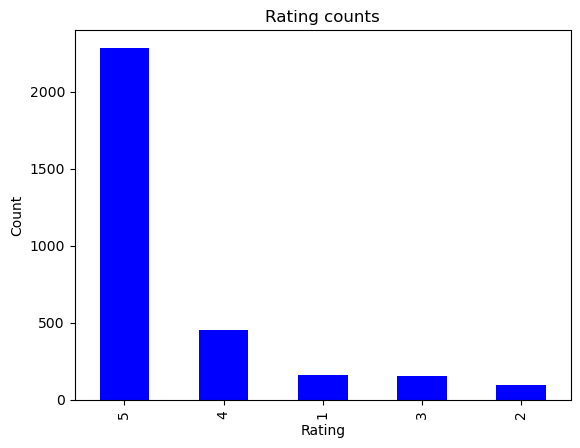

In [36]:
data['rating'].value_counts().plot.bar(color='blue')
plt.title('Rating counts')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [37]:
print("Percentage of each rating:")
print(round(data['rating'].value_counts()/len(data)*100, 2))

Percentage of each rating:
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


### Analyzing 'feedback' column

In [60]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

trying to find what the 0 and 1 tell

In [58]:
review_0 = data[data['feedback']==0].iloc[1]['verified_reviews']
print("Review with feedback '0':\n", review_0)

Review with feedback '0':
 Sound is terrible if u want good music too get a bose


In [59]:
review_1 = data[data['feedback']==1].iloc[1]['verified_reviews']
print("Review with feedback '1':\n", review_1)

Review with feedback '1':
 Loved it!


In [47]:
data[data['feedback']==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [48]:
data[data['feedback']==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

After some cross-checking, found out that feedback '1' corresponds to the reviews with ratings 3, 4 or 5, and the feedback '0' corresponds to the reviews with ratings 1 or 2.

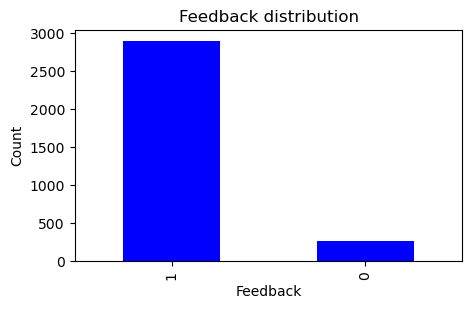

In [77]:
data['feedback'].value_counts().plot.bar(color='blue', figsize=(5,3))
plt.title('Feedback distribution')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [65]:
print("Feedback percentage distribution:")
print(round(data['feedback'].value_counts()/len(data)*100, 2))

Feedback percentage distribution:
feedback
1    91.87
0     8.13
Name: count, dtype: float64


### Analyzing 'variation' column

In [57]:
data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

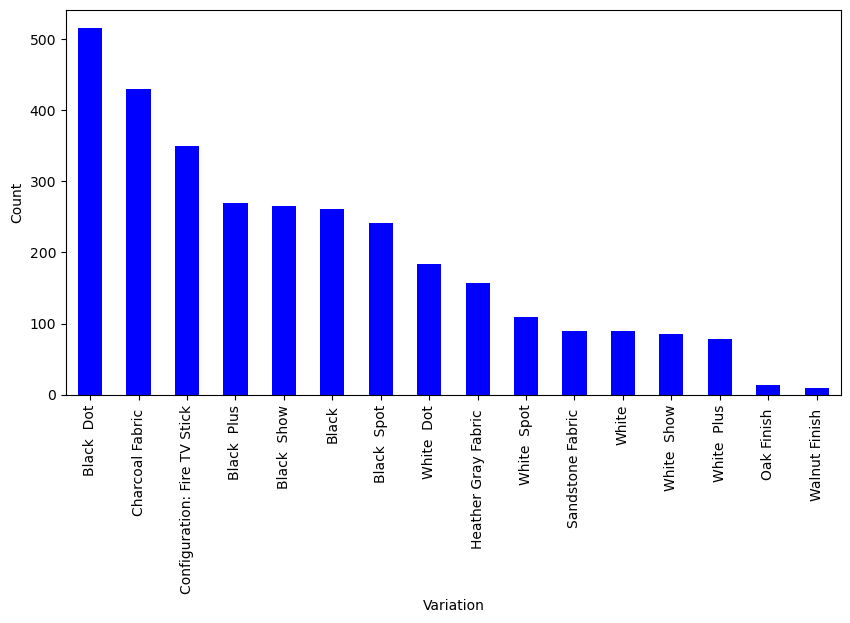

In [78]:
data['variation'].value_counts().plot.bar(color='blue', figsize=(10,5))
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [64]:
print("Variation percentage distribution:")
print(round(data['variation'].value_counts()/len(data)*100, 2))

Variation percentage distribution:
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


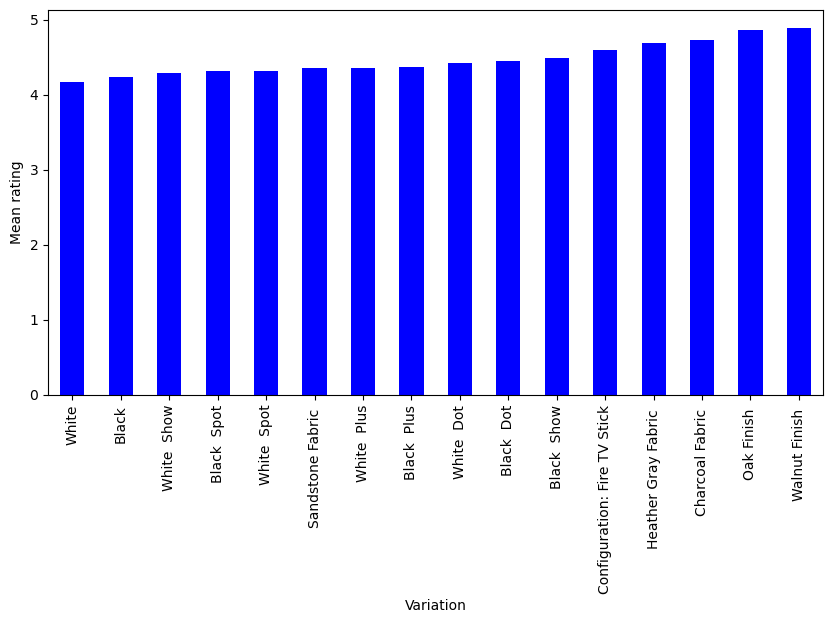

In [71]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color='blue', figsize=(10,5))
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

### Analyzing 'verified_reviews' column

In [80]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

<Axes: xlabel='length', ylabel='Count'>

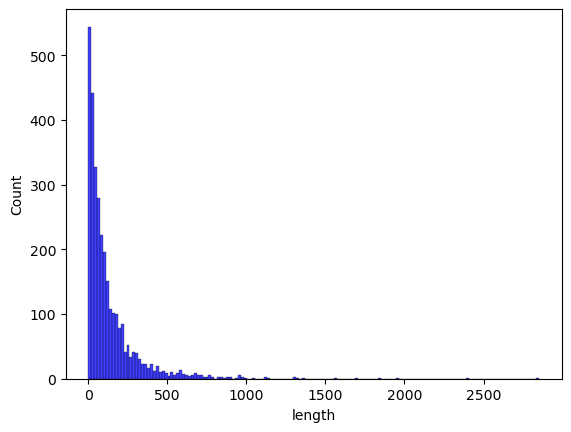

In [81]:
sns.histplot(data['length'], color='blue')

[Text(0.5, 1.0, 'for reviews with feedback 0')]

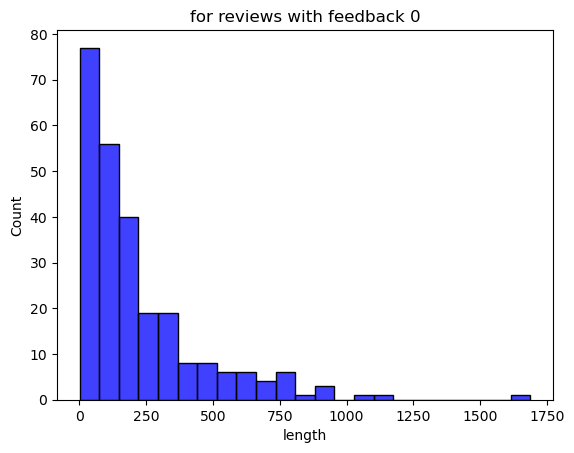

In [84]:
sns.histplot(data[data['feedback']==0]['length'], color='blue').set(title='for reviews with feedback 0')

[Text(0.5, 1.0, 'for reviews with feedback 1')]

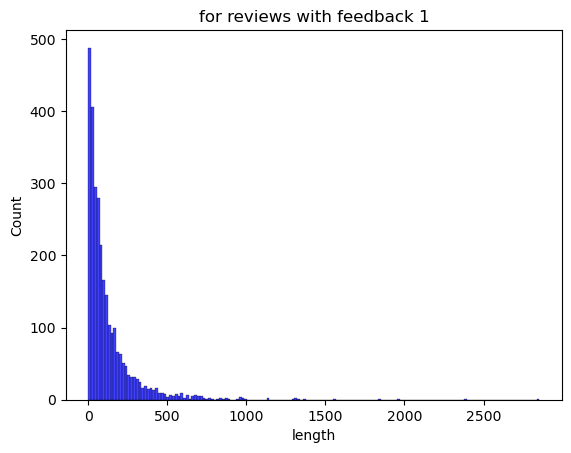

In [85]:
sns.histplot(data[data['feedback']==1]['length'], color='blue').set(title='for reviews with feedback 1')

<Axes: xlabel='rating'>

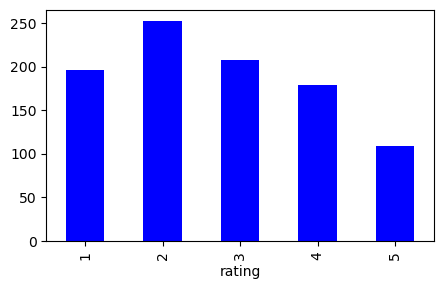

In [88]:
data.groupby('rating')['length'].mean().plot.bar(color='blue', figsize=(5,3))

In [89]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

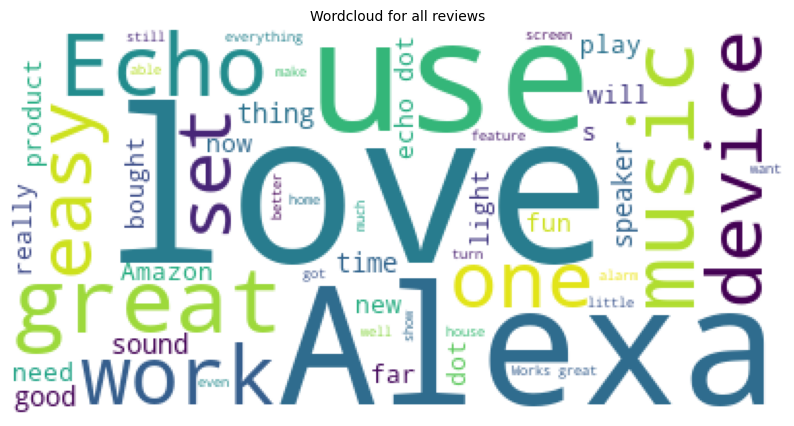

In [91]:
# combining all reviews
reviews = " ". join([review for review in data['verified_reviews']])

# initializing wordcloud object
wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [92]:
# combining all reviews for each feedback category and splitting them into individual words

neg_reviews = " ".join([review for review in data[data['feedback']==0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback']==1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

# finding words from reviews which are present only in that feedback category

unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

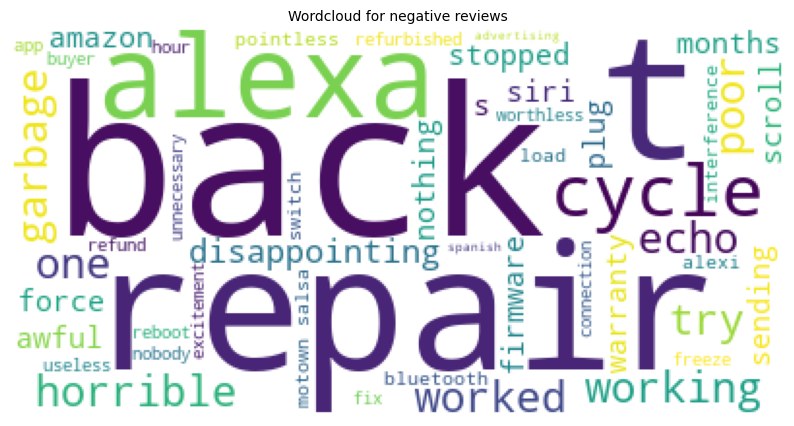

In [95]:
wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

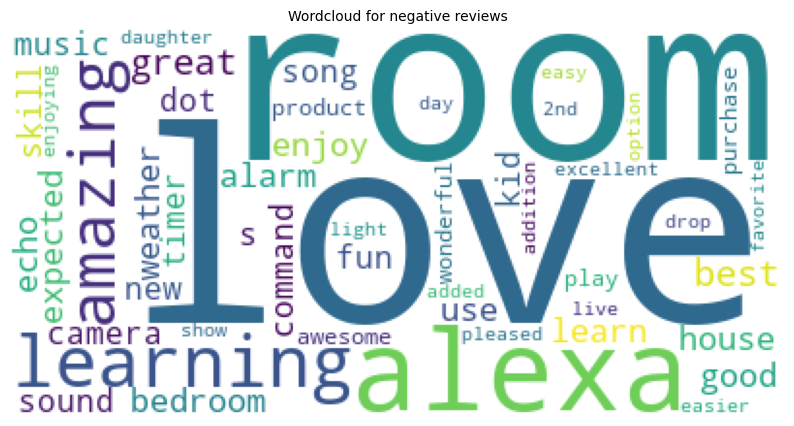

In [96]:
wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

## Preprocessing and Modelling

The steps we will follow to build the corpus using the 'verifies_reviews' column:
1) replace all non-alphabet characters with space
2) convert them into lower case and split into words
3) iterate over the split words and if they are not stop words then add their stemmed form to the corpus

In [97]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

using CountVectorizer to create bag of words

In [105]:
cv = CountVectorizer(max_features=2500)

# storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [106]:
# saving the CountVectorizer
pickle.dump(cv, open('models/countVectorizer.pkl', 'wb'))

In [100]:
X.shape

(3149, 2500)

In [101]:
y.shape

(3149,)

Splitting data into 70% for training and 30% for testing

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2204, 2500)
Shape of X_test: (945, 2500)
Shape of y_train: (2204,)
Shape of y_test: (945,)


In [107]:
X_train.max()

12

In [108]:
X_test.max()

10

We need to normalize all the values to bring them between 0 and 1.

In [112]:
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [113]:
# saving the scalar model
pickle.dump(scaler, open('models/scaler.pkl', 'wb'))

### Random Forests

In [115]:
rfc = RandomForestClassifier()
rfc.fit(X_train_sc, y_train)

RandomForestClassifier()

In [116]:
print("Training accuracy:", rfc.score(X_train_sc, y_train))
print("Testing accuracy:", rfc.score(X_test_sc, y_test))

Training accuracy: 0.9945553539019963
Testing accuracy: 0.9439153439153439


Random Forests seems overfitted

In [117]:
y_pred = rfc.predict(X_test_sc)

In [118]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

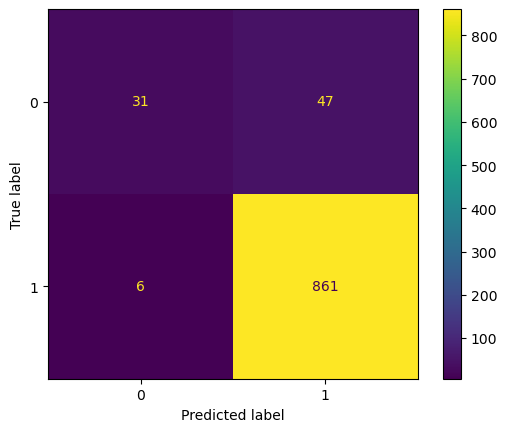

In [119]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
cm_display.plot()
plt.show()

In [120]:
# performing k-fold cross validation
accuracies = cross_val_score(estimator = rfc, X = X_train_sc, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9323961332784861
Standard Variance : 0.009826001458222482


applying grid search to get the optimal parameters on random forest

In [127]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [128]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = rfc, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_sc, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [129]:
print("Best Parameter Combination :", grid_search.best_params_)

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 100}


In [130]:
print("Cross validation mean accuracy on train set :", grid_search.cv_results_['mean_train_score'].mean()*100)
print("Cross validation mean accuracy on test set :", grid_search.cv_results_['mean_test_score'].mean()*100)
print("Accuracy score for test set :", accuracy_score(y_test, y_pred))

Cross validation mean accuracy on train set : 96.75022686025409
Cross validation mean accuracy on test set : 92.13929219600726
Accuracy score for test set : 0.9439153439153439


In [147]:
#Saving the Random Forests classifier
pickle.dump(rfc, open('models/randomForests.pkl', 'wb'))

### XGBoost

In [149]:
xgb = XGBClassifier()
xgb.fit(X_train_sc, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [150]:
print("Training Accuracy :", xgb.score(X_train_sc, y_train))
print("Testing Accuracy :", xgb.score(X_test_sc, y_test))

Training Accuracy : 0.971415607985481
Testing Accuracy : 0.9417989417989417


In [151]:
y_preds = xgb.predict(X_test)

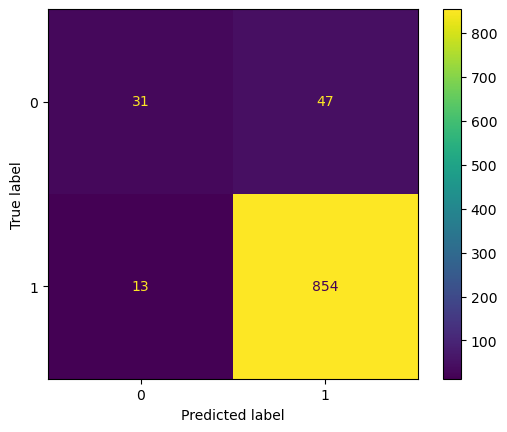

In [152]:
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
cm_display.plot()
plt.show()

In [153]:
#Saving the XGBoost classifier
pickle.dump(xgb, open('models/xgboost.pkl', 'wb'))

### Decision Tree Classifier

In [141]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_sc, y_train)

DecisionTreeClassifier()

In [142]:
print("Training Accuracy :", dtc.score(X_train_sc, y_train))
print("Testing Accuracy :", dtc.score(X_test_sc, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9248677248677248


Decision Tree seems overfitted too!

In [143]:
y_predss = dtc.predict(X_test)

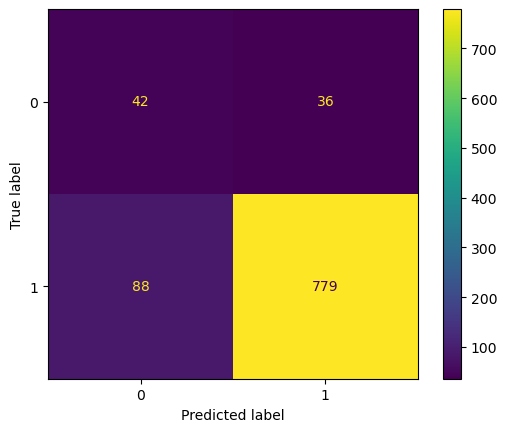

In [144]:
cm = confusion_matrix(y_test, y_predss)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
cm_display.plot()
plt.show()

In [146]:
#Saving the Decision Tree Classifier
pickle.dump(dtc, open('models/decisionTree.pkl', 'wb'))

**From the three models used, XGBoost seems to be the best because it is not overfitting as much as the other two.**